<a href="https://colab.research.google.com/github/Amineharrabi/Waste-Classifier-using-Keras-and-CV2/blob/main/WasteManagerV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


***Installing the libraries***

In [ ]:
!pip install opencv-python
!pip install tensorflow
!pip install keras==2.12.0
!pip install keras-cv==0.5.0
!pip install numpy==1.22.4
!pip install kaggle

***Importing the libraries***

In [66]:
import keras_cv
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os
from tensorflow.python.keras.layers import Dense, Flatten
from pathlib import Path
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam




***Importing the Data From Kaggle***

In [ ]:
!mkdir ~/.kaggle
!cp /content/sample_data/kaggle.json ~/.kaggle/
!chmod 1000 ~/.kaggle/kaggle.json
!kaggle datasets download -d arkadiyhacks/drinking-waste-classification
!kaggle datasets download -d techsash/waste-classification-data
!unzip drinking-waste-classification
!unzip waste-classification-data

In [ ]:
!kaggle datasets download -d sumn2u/garbage-classification-v2
!unzip garbage-classification-v2

In [13]:
!mv /content/sample_data/DATASET/TRAIN/O  /content/sample_data/Images_of_Waste/rawimgs

In [11]:
!mv /content/sample_data/Garbage-Classification/paper  /content/sample_data/Images_of_Waste/rawimgs

In [10]:
!mv /content/sample_data/Garbage-Classification/battery  /content/sample_data/Images_of_Waste/rawimgs

In [68]:
import os

PATH = '/content/sample_data'

os.chdir(PATH)

***Model Creation***

In [69]:
from PIL import Image
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_v2_imagenet",
    num_classes=28,
    bounding_box_format="xywh",
)






# **Debugging (optional)**

In [ ]:
i = 123
data_dir = Path('/content/sample_data/Images_of_Waste/rawimgs')

trash = list(data_dir.glob('AluCan/*'))
#trash = list(data_dir.glob('exemples/*'))
print(trash[i])

Image.open(str(trash[i]))

In [72]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20385 files belonging to 7 classes.
Using 16308 files for training.


In [73]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20385 files belonging to 7 classes.
Using 4077 files for validation.


In [74]:
class_names = train_ds.class_names
print(class_names)

['AluCan', 'Glass', 'HDPEM', 'O', 'PET', 'battery', 'paper']


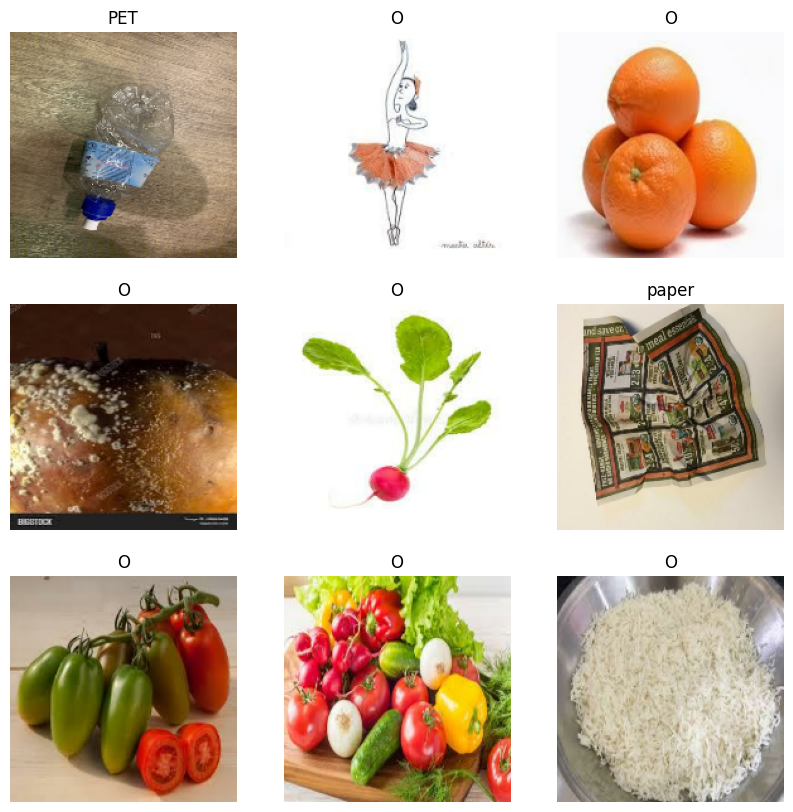

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

***Model Training***

In [76]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=7,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(7,activation='softmax'))

In [77]:
resnet_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_6 (ModuleWra  (None, 2048)             0         
 pper)                                                           
                                                                 
 module_wrapper_7 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_8 (ModuleWra  (None, 7)                3591      
 pper)                                                           
                                                                 
Total params: 24,640,391
Trainable params: 1,052,679
Non-trainable params: 23,587,712
__________________________________

***Converting The Images To the correct Format (JPEG)***

In [ ]:
import os
def convert_images_to_jpeg(folder_path):
    folder_path = folder_path.rstrip('/') + '/'

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if os.path.isfile(file_path) and any(filename.lower().endswith(ext) for ext in ['.png', '.jpg', '.jpeg', '.gif']):
            try:
                img = Image.open(file_path)

                new_filename = os.path.splitext(filename)[0] + '.jpeg'
                new_file_path = os.path.join(folder_path, new_filename)
                img.convert('RGB').save(new_file_path, 'JPEG')

                img.close()

                os.remove(file_path)

                print(f"Converted {filename} to {new_filename}")
            except Exception as e:
                print(f"Error converting {filename}: {e}")

if __name__ == "__main__":
    folder_path = input("Enter the folder path: ")
    convert_images_to_jpeg(folder_path)


In [41]:
epochs = 2
resnet_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [42]:

history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/2
510/510 [==============================] - 2952s 6s/step - loss: 0.1851 - accuracy: 0.9409 - val_loss: 0.1016 - val_accuracy: 0.9681
Epoch 2/2
510/510 [==============================] - 2968s 6s/step - loss: 0.0670 - accuracy: 0.9760 - val_loss: 0.0968 - val_accuracy: 0.9693


***Model Evaluation***

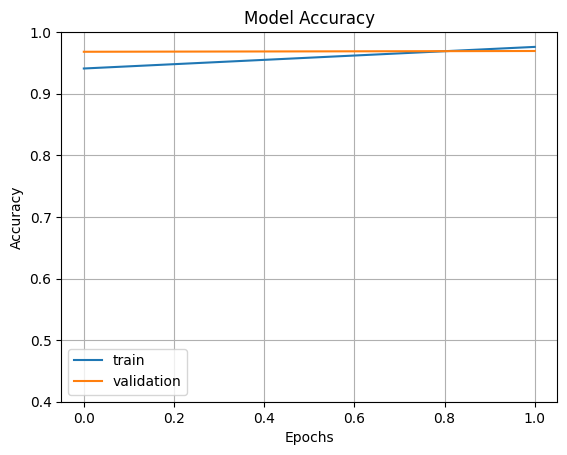

In [79]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


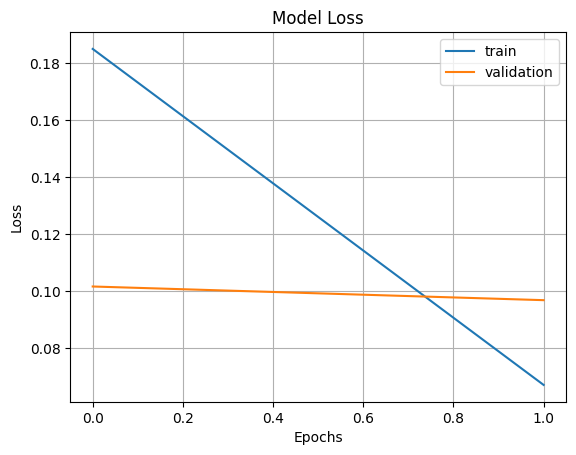

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

***Custom predictions***

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow
import cv2
import keras


def capture_frame():
    js = Javascript('''
        async function captureFrame() {
            const div = document.createElement('div');
            document.body.appendChild(div);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({ 'video': true });

            document.body.appendChild(video);
            video.srcObject = stream;

            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            context.drawImage(video, 0, 0, video.videoWidth, video.videoHeight);

            const imageData = canvas.toDataURL('image/jpeg');

            return imageData;
        }
        ''')
    display(js)
    class_names = ['cat', 'dog']
    data = eval_js('captureFrame()')
    binary = b64decode(data.split(',')[1])
    frame = np.asarray(bytearray(binary), dtype=np.uint8)
    return cv2_imshow(frame)



while (True):
  frame = capture_frame()
  cv2.waitKey(100)
  pred=model.predict(frame)
  output_class=class_names[np.argmax(pred)]
  print("The predicted class is", output_class)

cv2.destroyAllWindows()

In [ ]:
import cv2
image=cv2.imread(str(trash[i]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)
Image.open(str(trash[i]))

In [99]:
pred=resnet_model.predict(image)
print(pred)


1/1 [==============================] - 0s 165ms/step
[[0.22897877 0.22121687 0.04100227 0.05632165 0.22205612 0.17947659
  0.05094777]]


In [100]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is AluCan
